In [1]:
import pathlib

In [2]:
%matplotlib inline
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

In [3]:
from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
from dask.diagnostics import ProgressBar

In [6]:
from ICU_Water_Watch import MSWEP, domains, geo, plot, utils

In [7]:
dpath = "/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge"
dpath_shapes = "/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles"
domain_name = "SP"
nbdays_agg = 90
lag_to_realtime = 2
varname = "precipitation"
fig_kwargs = dict(dpi=200, bbox_inches="tight", facecolor="w")
clim_start = 1991
clim_stop = 2020

In [8]:
dpath = pathlib.Path(dpath).joinpath(f"{domain_name}/outputs")
dpath_shapes = pathlib.Path(dpath_shapes)

In [9]:
today = datetime.utcnow().date()
date_stop = today - timedelta(days=lag_to_realtime)

In [10]:
today

datetime.date(2023, 5, 5)

In [11]:
date_stop

datetime.date(2023, 5, 3)

In [12]:
# %% get the EEZs shapefiles, individual + merged
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes=dpath_shapes)

In [13]:
# %% get the coastlines
coastlines = geo.get_coastlines(dpath_shapes=dpath_shapes)

In [14]:
fname = dpath.joinpath(f"MSWEP_dset_merged_{nbdays_agg}days_to_{date_stop:%Y-%m-%d}.nc")

In [15]:
fname.exists()

True

In [16]:
dset = xr.open_dataset(fname, chunks={"time": "auto", "lat": 50, "lon": 50})

In [17]:
attrs = {
    k: dset.attrs[k]
    for k in [
        "ndays",
        "last_day",
        "DOY",
    ]
}

## get the time, then squeeze

In [18]:
dset_date = dset["time"]

In [19]:
dset_date = pd.Timestamp(dset_date.to_numpy()[0])

In [20]:
dset_date

Timestamp('2023-05-03 00:00:00')

In [21]:
dset_date == pd.Timestamp(date_stop)

True

In [22]:
dset = dset.squeeze()

In [23]:
dset = geo.make_mask_from_gpd(
    dset, merged_EEZs, subset=False, insert=True, mask_name="EEZs"
)

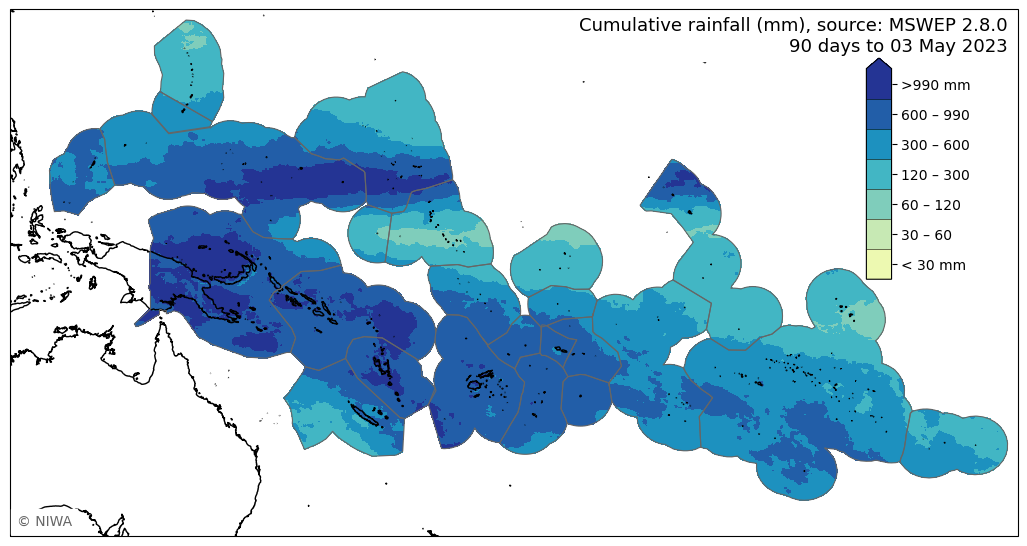

In [24]:
plot.map_precip_accum(
    dset,
    varname=varname,
    mask="EEZs",
    geoms=EEZs,
    source="MSWEP 2.8.0",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

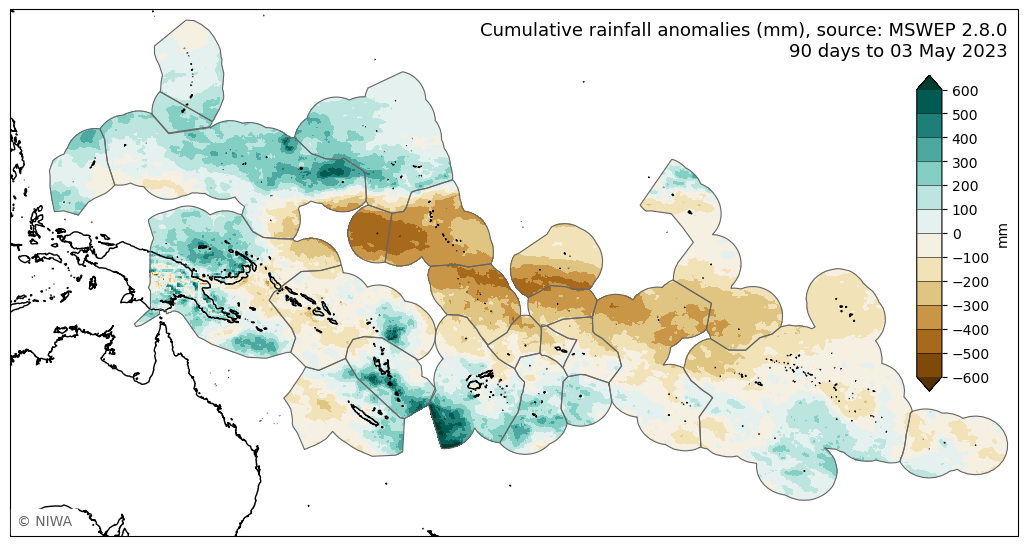

In [25]:
plot.map_precip_anoms(
    dset,
    varname="anoms",
    mask="EEZs",
    geoms=EEZs,
    source="MSWEP 2.8.0",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

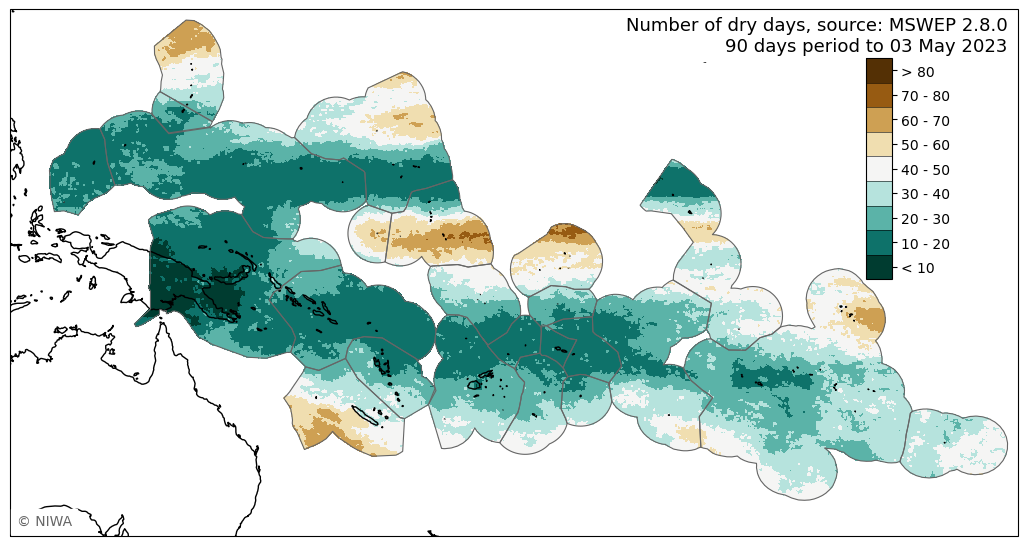

In [26]:
plot.map_dry_days_Pacific(
    dset,
    varname="dry_days",
    mask="EEZs",
    geoms=EEZs,
    source="MSWEP 2.8.0",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

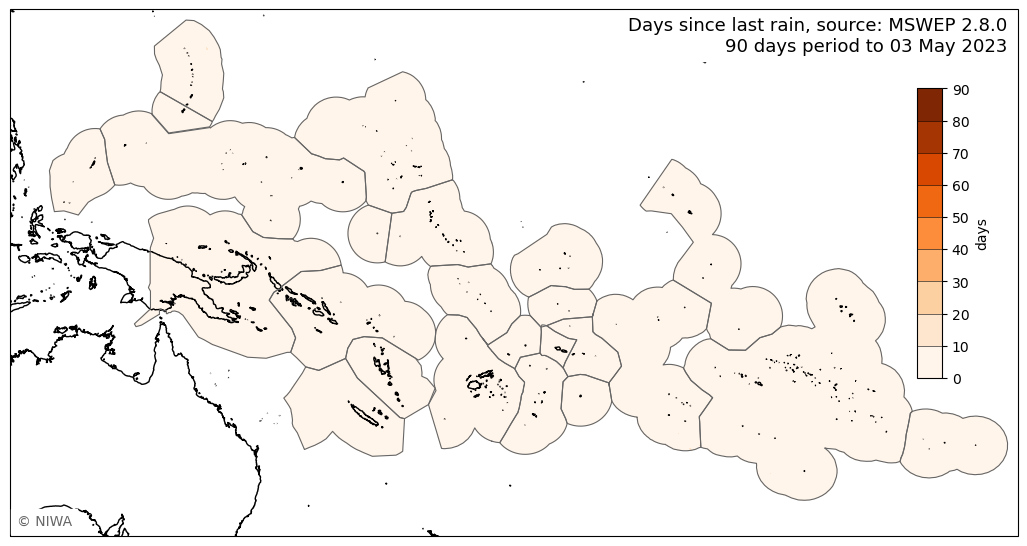

In [27]:
plot.map_days_since_rain_Pacific(
    dset,
    varname="days_since_rain",
    mask="EEZs",
    geoms=EEZs,
    source="MSWEP 2.8.0",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

### Now we get the quantiles defining the 'EAR Watch' categories

In [28]:
dset.coords["quantile"]

<xarray.DataArray 'quantile' (quantile: 15)>
array([0.02  , 0.05  , 0.1   , 0.2   , 0.25  , 0.3   , 0.3333, 0.4   , 0.5   ,
       0.6   , 0.6666, 0.7   , 0.75  , 0.8   , 0.9   ])
Coordinates:
    time      datetime64[ns] 2023-05-03
    DOY       int64 ...
  * quantile  (quantile) float64 0.02 0.05 0.1 0.2 0.25 ... 0.7 0.75 0.8 0.9

In [29]:
EAR_threshs = [0.05, 0.1, 0.25, 0.9]

In [30]:
EAR_quantiles = dset[["precipitation_quantiles"]].sel(quantile=EAR_threshs)

In [31]:
EAR_colors_list = ["#F04E37", "#F99D1C", "#FFDE40", "#FFFFFF", "#33BBED"]

In [32]:
EAR_labels = [
    "Severely dry (< 5%)",
    "Seriously dry (< 10%)",
    "Warning (< 25%)",
    "Near or Wetter",
    "Seriously wet (> 90%)",
]

In [33]:
def _digitize(x, bins):
    return np.digitize(x.ravel(), bins.ravel())

In [34]:
EAR_categories = xr.apply_ufunc(
    _digitize,
    dset[varname],
    EAR_quantiles[f"{varname}_quantiles"],
    input_core_dims=[[], ["quantile"]],
    vectorize=True,
    dask="parallelized",
)

In [35]:
with ProgressBar():
    EAR_categories = EAR_categories.compute()

[########################################] | 100% Completed | 30.74 s


In [36]:
EAR_categories.attrs = attrs

In [37]:
title = f'Water Stress (aligned to "EAR" alert levels), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}'

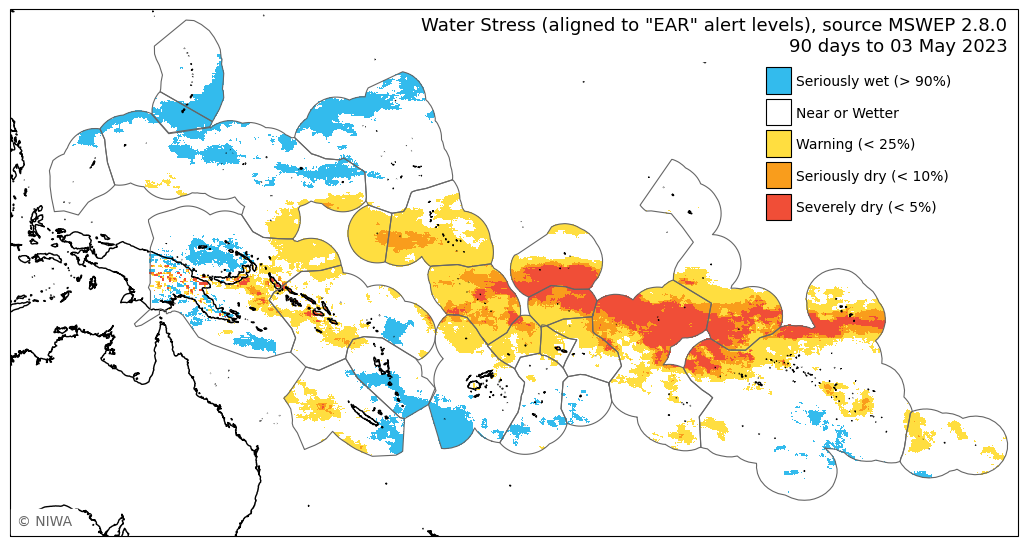

In [38]:
plot.map_categories(
    EAR_categories,
    mask=dset["EEZs"],
    colors_list=EAR_colors_list,
    labels_list=EAR_labels,
    geoms=EEZs,
    extent=domains.domains["Water_Watch"],
    gridlines=False,
    title=title,
    figname_root="EAR",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

### Now plot the USDM levels

In [39]:
USDM_threshs = [0.02, 0.05, 0.1, 0.2, 0.3]

In [40]:
USDM_quantiles = dset[["precipitation_quantiles"]].sel(quantile=USDM_threshs)

In [41]:
USDM_colors_list = ["#8a0606", "#fc0b03", "#fc9003", "#ffd08a", "#ffeb0f", "#ffffff"]

In [42]:
USDM_labels = [
    "D4 (Exceptional Drought)",
    "D3 (Extreme Drought)",
    "D2 (Severe Drought)",
    "D1 (Moderate Drought)",
    "D0 (Abnormally Dry)",
    "None",
]

In [43]:
USDM_categories = xr.apply_ufunc(
    _digitize,
    dset[varname],
    USDM_quantiles[f"{varname}_quantiles"],
    input_core_dims=[[], ["quantile"]],
    vectorize=True,
    dask="parallelized",
)

In [44]:
with ProgressBar():
    USDM_categories = USDM_categories.compute()

[########################################] | 100% Completed | 30.17 s


In [45]:
USDM_categories.attrs = attrs

In [46]:
title = f"US Drought Monitor (USDM), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}"

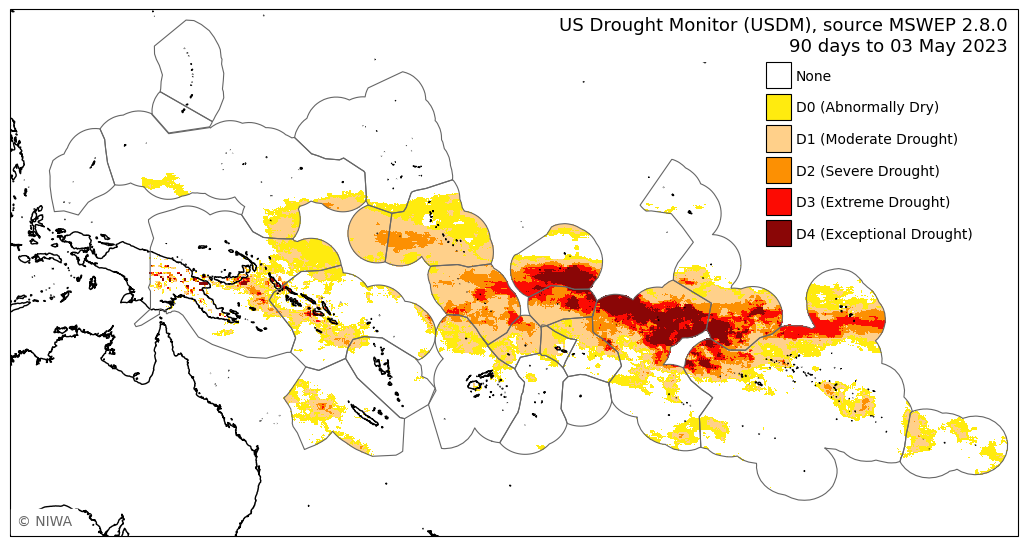

In [47]:
plot.map_categories(
    USDM_categories,
    mask=dset["EEZs"],
    colors_list=USDM_colors_list,
    labels_list=USDM_labels,
    geoms=EEZs,
    extent=domains.domains["Water_Watch"],
    gridlines=False,
    title=title,
    figname_root="USDM",
    fpath="../../figures/MSWEP_dev/",
    cbar_yanchor=0.55,
)

### Now onto the SPI 

In [ ]:
SPI = MSWEP.calculate_SPI(dset[varname], dset["alpha"], dset["beta"], name="SPI")

In [ ]:
SPI

In [ ]:
SPI_threshs = [-2, -1.5, -1, 1, 1.5, 2]

In [ ]:
SPI_categories = np.digitize(SPI["SPI"].data, SPI_threshs)

In [ ]:
SPI_categories.shape

In [ ]:
SPI["SPI_categories"] = (("lat", "lon"), SPI_categories)

In [ ]:
SPI_colors_list = ["#F04E37", "#F99D1C", "#FFDE40", "#FFFFFF", "#96ceff", "#4553bf", "#09146b"]

In [ ]:
SPI_labels = [
    "Extremely dry",
    "Severely dry",
    "Moderately dry",
    "Near normal",
    "Moderately wet",
    "Severely wet",
    "Extremely wet",
]

In [ ]:
title = f"Standardized Precipitation Index (SPI), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}"

In [ ]:
SPI["SPI_categories"].attrs = attrs

In [ ]:
plot.map_categories(
    SPI["SPI_categories"],
    mask=dset["EEZs"],
    colors_list=SPI_colors_list,
    labels_list=SPI_labels,
    geoms=EEZs,
    extent=domains.domains["Water_Watch"],
    gridlines=False,
    spacing={"lon": 20, "lat": 10},
    title=title,
    cbar_yanchor=0.495,
    cbar_xanchor=0.85,
    figname_root="SPI",
    fpath="../../figures/MSWEP_dev/",
    close=False,
)

In [ ]:
EAR_categories_ds = EAR_categories.to_dataset(name="EAR_categories")

In [ ]:
USDM_categories_ds = USDM_categories.to_dataset(name='USDM_categories')

In [ ]:
SPI_categories_ds = SPI[['SPI_categories']]

In [ ]:
for country_name in coastlines.country_na.values:

    country_fname = utils.sanitize_name(country_name)
    
    EEZ = EEZs.query(f"COUNTRYNAM == '{country_name}'")

    coastline = coastlines.query(f"country_na == '{country_name}'")
    
    SPI_categories_subset = geo.make_mask_from_gpd(SPI_categories_ds, EEZ, subset=True, mask_name='mask_EEZ', domain_buffer=0.2)
    EAR_categories_subset = geo.make_mask_from_gpd(EAR_categories_ds, EEZ, subset=True, mask_name='mask_EEZ', domain_buffer=0.2)
    USDM_categories_subset = geo.make_mask_from_gpd(USDM_categories_ds, EEZ, subset=True, mask_name='mask_EEZ', domain_buffer=0.2)
    
    
    plot.map_categories(
    SPI_categories_subset['SPI_categories'],
    mask=SPI_categories_subset["mask_EEZ"],
    colors_list=SPI_colors_list,
    labels_list=SPI_labels,
    geoms=[EEZ, coastline],
    extent=domains.get_domain(SPI_categories_subset),
    gridlines=True,
    cartopy_coastlines=False,
    spacing={"lon": 2.5, "lat": 2.5},
    title=f"SPI, {country_name}, {nbdays_agg} days to {date_stop:%Y-%m-%d}",
    figname_root=f"SPI_{country_fname}", 
    fpath='../../figures/MSWEP_dev/',
    cbar_xanchor=1.01,
    cbar_yanchor=0,
    title_top=True, 
    close=True,
    )

    plot.map_categories(
    EAR_categories_subset['EAR_categories'],
    mask=EAR_categories_subset["mask_EEZ"],
    colors_list=EAR_colors_list,
    labels_list=EAR_labels,
    geoms=[EEZ, coastline],
    extent=domains.get_domain(SPI_categories_subset),
    gridlines=True,
    cartopy_coastlines=False,
    spacing={"lon": 2.5, "lat": 2.5},
    title=f"EAR, {country_name}, {nbdays_agg} days to {date_stop:%Y-%m-%d}",
    figname_root=f"EAR_{country_fname}", 
    fpath='../../figures/MSWEP_dev/',
    cbar_xanchor=1.01,
    cbar_yanchor=0,
    title_top=True, 
    close=True,
    )
    
    plot.map_categories(
    USDM_categories_subset['USDM_categories'],
    mask=USDM_categories_subset["mask_EEZ"],
    colors_list=USDM_colors_list,
    labels_list=USDM_labels,
    geoms=[EEZ, coastline],
    extent=domains.get_domain(SPI_categories_subset),
    gridlines=True,
    cartopy_coastlines=False,
    spacing={"lon": 2.5, "lat": 2.5},
    title=f"USDM, {country_name}, {nbdays_agg} days to {date_stop:%Y-%m-%d}",
    figname_root=f"USDM_{country_fname}", 
    fpath='../../figures/MSWEP_dev/',
    cbar_xanchor=1.01,
    cbar_yanchor=0,
    title_top=True, 
    close=True,
    )